In [1]:
import json
import itertools
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)
sns.set(font_scale = 1.9)
%matplotlib inline

In [2]:
with open('data/train.json') as data:
  dishes = json.load(data)

In [3]:
print("There are {0} total recipes.".format(len(dishes)))
dishes[0]

There are 39774 total recipes.


{'id': 10259,
 'cuisine': 'greek',
 'ingredients': ['romaine lettuce',
  'black olives',
  'grape tomatoes',
  'garlic',
  'pepper',
  'purple onion',
  'seasoning',
  'garbanzo beans',
  'feta cheese crumbles']}

In [4]:
a = pd.DataFrame.from_dict(dishes)
print("There are {0} total cuisines available.".format(len(a['cuisine'].unique())))
a['cuisine'].value_counts()

There are 20 total cuisines available.


italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

In [5]:
def get_combinations(l):
    '''input list of items and output all pair edges'''
    g = []
    for i in itertools.combinations(l ,2):
        g.append(i)
    return g

In [6]:
new_dict = []

for dish in dishes:
    edges_list = get_combinations(dish['ingredients'])
    for edges in edges_list:
        new_dict.append({'id':dish['id'], 'cuisine':dish['cuisine'], 'source': edges[0], 'target': edges[1]})  

In [7]:
edge_df = pd.DataFrame.from_dict(new_dict).groupby(['source', 'target', 'cuisine']).size().reset_index(name='count')

In [8]:
edge_df.sort_values(by='count', ascending=False)[:10].reset_index(drop=True)

,source,target,cuisine,count
0,olive oil,salt,italian,1013
1,olive oil,garlic cloves,italian,582
2,salt,olive oil,italian,582
3,ground black pepper,salt,italian,524
4,salt,onions,indian,519
5,pepper,salt,italian,517
6,olive oil,garlic,italian,504
7,olive oil,salt,mexican,466
8,salt,onions,mexican,446
9,pepper,salt,mexican,443


In [9]:
node_dfs = []

for cuisine, g in edge_df.groupby(['cuisine']):
    count = g['source'].append(g['target']).value_counts(normalize=True)
    count = pd.DataFrame({'cuisine':cuisine, 'node':count.index, 'size':count.values})
    node_dfs.append(count)
    
node_df = pd.concat(node_dfs, names=['cuisine', 'node', 'size'])
node_df.head()

,cuisine,node,size
0,brazilian,salt,0.020707
1,brazilian,onions,0.015831
2,brazilian,olive oil,0.015612
3,brazilian,garlic,0.012627
4,brazilian,water,0.012517


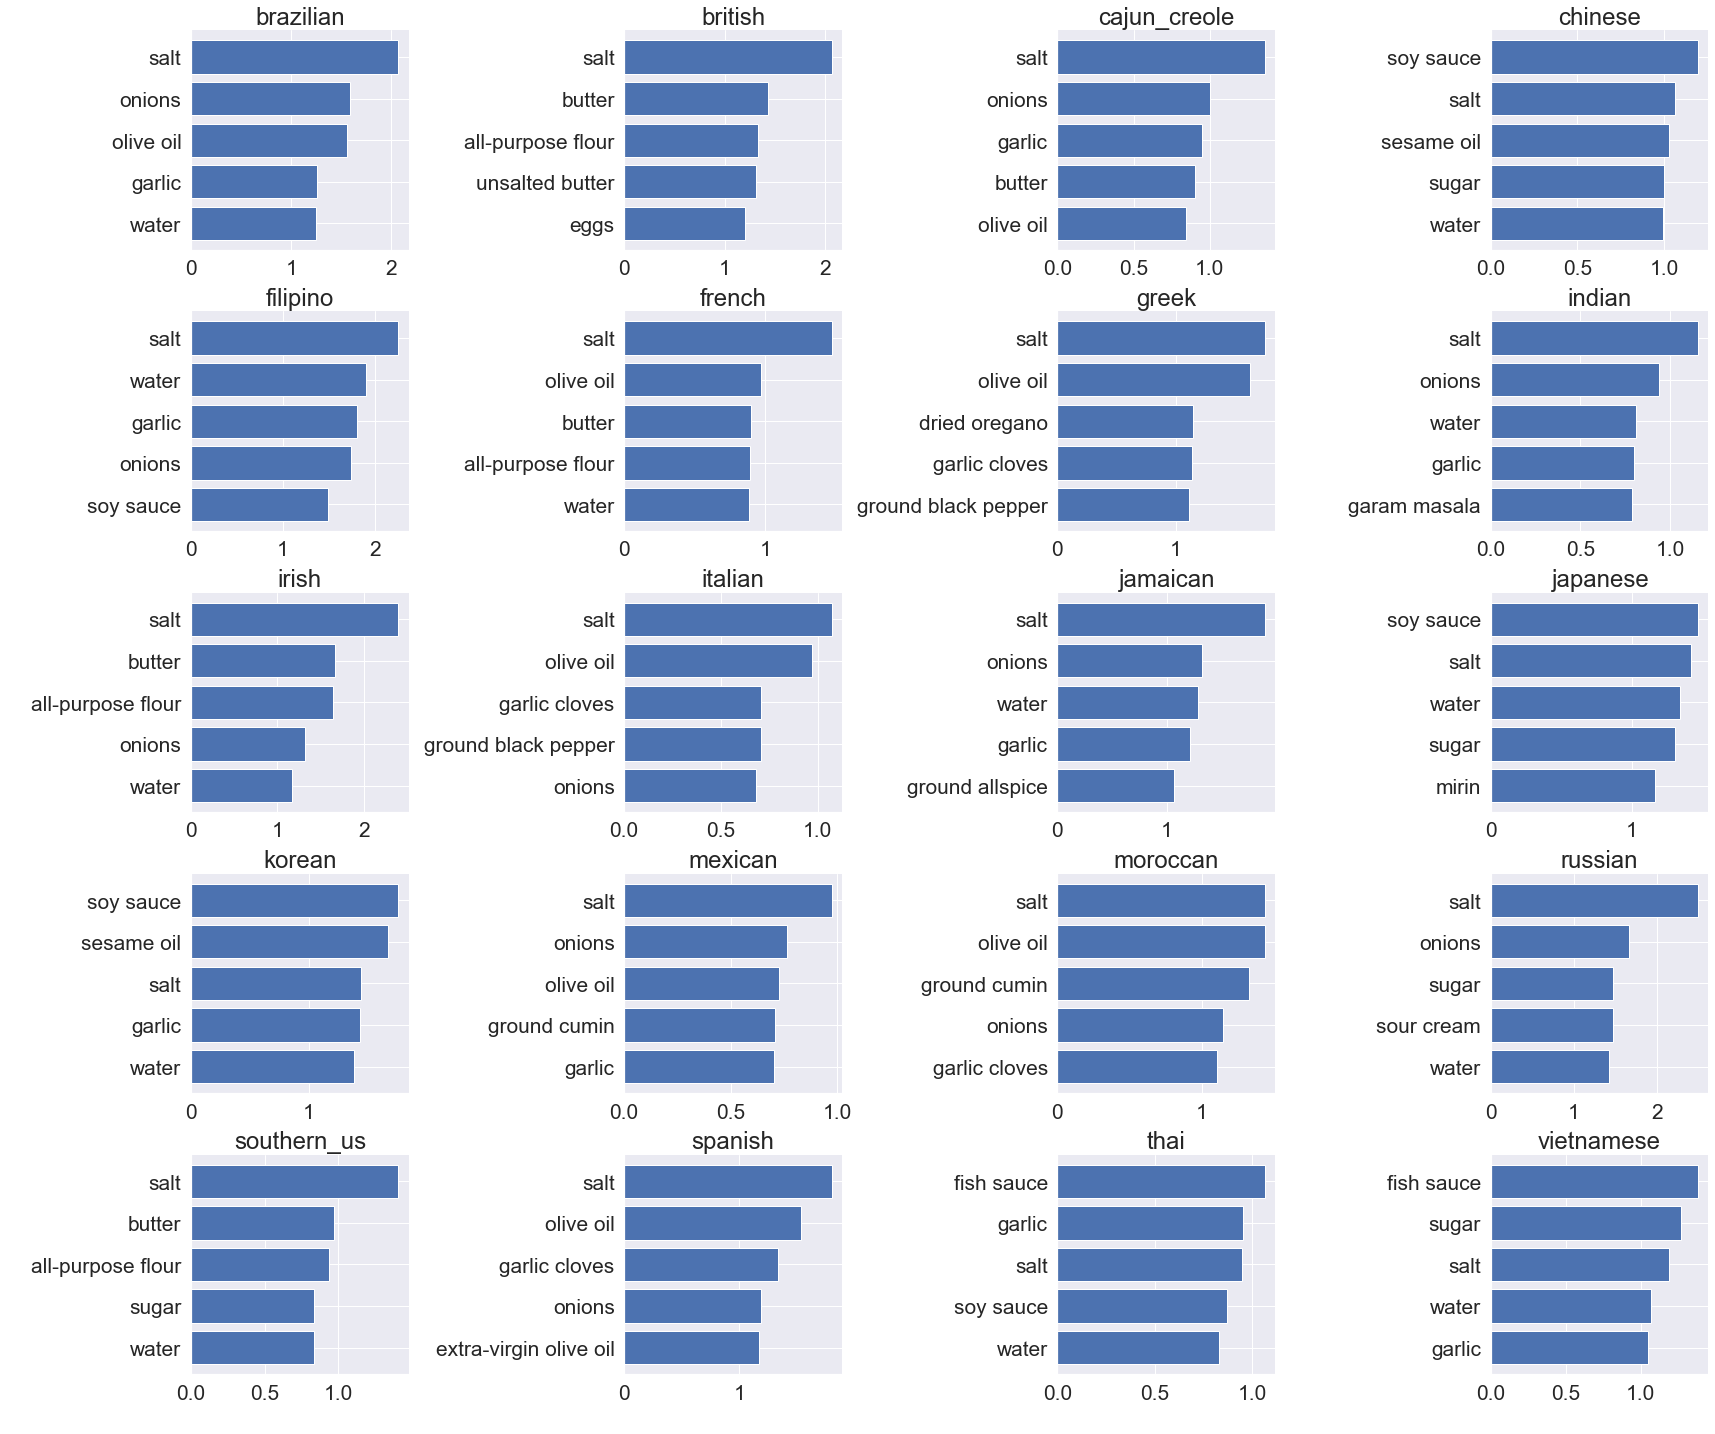

In [10]:
data = node_df.sort_values(['cuisine', 'size'], ascending=False).groupby('cuisine').head(5)
data['size'] = data['size'] * 100

# To view all styles: plt.style.available
# https://cduvallet.github.io/posts/2018/11/facetgrid-ylabel-access
g = sns.FacetGrid(data.sort_values(['cuisine', 'size']), col='cuisine', col_wrap=4, sharey=False, sharex=False, 
                  height=4, aspect=1.5)

g = g.map(plt.barh, 'node', 'size', color='b')
g.set_titles(col_template="{col_name}", size=24)
g.set_xlabels(' ')
g.set_ylabels(' ')

In [11]:
#https://stackoverflow.com/questions/23377108/pandas-percentage-of-total-with-groupby
# data = node_df.groupby(['node']).apply(lambda x: x/x.sum())


In [12]:
# for i in ['vietnamese', 'chinese']:
#     n = node_df[node_df['cuisine'] == i]
#     e = edge_df[edge_df['cuisine'] == i]
    
#     G = nx.Graph()
#     for node in n['node'].unique():
#         G.add_node(node)
        
#     nx.draw_networkx_nodes(G=G, pos=nx.spring_layout(G), node_list=G.nodes(), node_color='royalblue',
#                        alpha=0.8, node_size=(n['size']/1000).tolist())
#     nx.draw_networkx_edges(G=G, pos=nx.spring_layout(G), edge_color='red', alpha=0.2,
#                        width=e['count'], arrows=False)